# Analysis dataset toy

In [47]:
import numpy as np
import pickle as pkl
from multiprocessing import Pool
from p_tqdm import p_map
from matplotlib import pyplot as plt
from collections import Counter
import glob

In [48]:
path = ('/data/vision/torralba/frames/data_acquisition/SyntheticStories/online_wah/agent_preferences/'
        'dataset_episodes_noscratch/data_structured/train_env_task_set_150_full_task.all/*/*')

In [49]:
path = ('/data/vision/torralba/frames/data_acquisition/SyntheticStories/online_wah/agent_preferences/'
        'dataset_episodes_noscratch/data_structured/test_env_task_set_60_full_task.all/*/*')

In [50]:
episodes = glob.glob(path)

In [51]:
with open(episodes[0], 'rb') as f:
    cont = pkl.load(f)

In [52]:
len(episodes)

336

In [53]:
def get_task_type(episode_content):
    if type(episode_content) == str:
        with open(episode_content, 'rb') as f:
            episode_content = pkl.load(f)
    goals = episode_content['gt_goals']
    num_preds = sum([g['count'] for g in goals.values()])
    name_preds = [goal_name.split('_')[1] for goal_name in goals.keys()]
    return {'pred_name': episode_content['task_name'], 'num_preds': num_preds}
    

In [54]:
def get_task_info(episode_content):
#     print(episode_content)
    if type(episode_content) == str:
        with open(episode_content, 'rb') as f:
            episode_content = pkl.load(f)
    
    if 'action' not in episode_content:
        return {}
    else:
        length = len(episode_content['action'][0])
    
    # Check distribution of objects
    first_graph = episode_content['graph'][0]
    objects_interest = ['cupcake', 'salmon', 'apple', 'plate', 'waterglass', 
                    'cutleryfork', 'wineglass', 'pudding', 'remotecontrol', 'condimentbottle', 'chips']
    obj2id = {name:index for index, name in enumerate(objects_interest)}
    
    object_relation_count = {}
    count_obj = [0 for _ in objects_interest]
    for object_name in objects_interest: 
        object_relation_count[object_name] = []
        
    id2node = {node['id']: node for node in first_graph['nodes']}
    
    # For every destination object, check the different locations
    for edge in first_graph['edges']:
        class_name = id2node[edge['from_id']]['class_name']
        if class_name in objects_interest:
            class_name_dest = id2node[edge['to_id']]['class_name']
            relation = edge['relation_type'].lower()
            if relation in ['close', 'facing']:
                continue
            full_relation_name = f'{relation}.{class_name_dest}'
            object_relation_count[class_name].append(full_relation_name)
    
    for node in first_graph['nodes']:
        class_name = node['class_name']
        if class_name in objects_interest:
            class_name_id = obj2id[class_name]
            count_obj[class_name_id] += 1
            
    # Counter over relations
    for class_name in objects_interest:
        object_relation_count[class_name] = Counter(object_relation_count[class_name])
    
    info = get_task_type(episode_content)
    info.update({'count_obj': count_obj})
    info.update({'obj_relations': object_relation_count})
    info['len_prog'] = length
    info['finished'] = episode_content['finished']
    actions_all = episode_content['action'][0]
    actions_all = [x for x in actions_all if '[close]' in x]
    info['has_close'] = len(actions_all) > 0
    return info
    

In [ ]:
# episodes = list(cont.keys())
with open(episodes[0], 'rb') as f:
    content_episode = pkl.load(f)

In [55]:
results = p_map(get_task_info, episodes)
# results = [get_task_info(episode) for episode in episodes]

In [ ]:
cont = [x['has_close'] for x in results if 'has_close' in x]

In [ ]:
with open(episodes[2], 'rb') as f:
    cont2 = pkl.load(f)


In [ ]:
episodes[4]

In [ ]:
cont2['action'][0][28:]

In [ ]:
print(cont2['gt_goals']['inside_pudding_163'])
print([node for node in cont2['graph'][28]['nodes'] if node['id'] in [163, 1]])

print('\n')
print([node for node in cont2['graph'][29]['nodes'] if node['id'] in [163, 1]])


In [ ]:
cont2.keys()

In [ ]:
len(cont2['goals_finished'])

In [ ]:
cont2['gt_goals']

In [ ]:
def modify_program(prog_info):
    return prog_info

# Modify close action

In [62]:
import copy
import ipdb
def modify_program(prog_info_name):
    with open(prog_info_name, 'rb') as f: 
        prog_info = pkl.load(f)
    prog_info = copy.deepcopy(prog_info)
    if 'gt_goals' not in prog_info:
        return 0
    goal = prog_info['gt_goals']
    object_ids_modify = [x for x in goal.keys() if 'inside' in x]
    ids_modify = [goal[x]['container_ids'][0] for x in object_ids_modify]
    if len(ids_modify) == 0 or not prog_info['finished']:
        return 0
    for object_id in ids_modify:
        # Get the first time we open it
        action_id = [index for index, action in enumerate(prog_info['action'][0]) 
                     if ('[open]' in action or '[close]' in action) and f'({object_id})' in action]
        
        if len(action_id) < 2:
            return 0
        first_close = action_id[1]
        for cgraph in prog_info['graph'][first_close+1:]:
            cnode = [node for node in cgraph['nodes'] if node['id'] == object_id][0]
            cnode['states'] = ['OPEN']
            
        delete_positions = action_id[1:]
        
        # Delete
        prog_info['goals_finished'] = [action for it, action in enumerate(prog_info['goals_finished']) if it not in delete_positions]
        prog_info['action'][0] = [action for it, action in enumerate(prog_info['action'][0]) if it not in delete_positions]
        prog_info['plan'][0] = [action for it, action in enumerate(prog_info['plan'][0]) if it not in delete_positions]
        
        prog_info['graph'] = [action for it, action in enumerate(prog_info['graph']) if it-1 not in delete_positions]
        prog_info['obs'] = [action for it, action in enumerate(prog_info['obs']) if it-1 not in delete_positions]
    with open(prog_info_name, 'wb') as f:
        pkl.dump(prog_info, f)
    return 1

In [63]:
# ind = 0
# for episode in episodes:
#     print(ind)
#     modify_program(episode)
#     ind += 1

p_map(modify_program, episodes)

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [ ]:
new_cont['action']

## DONE

In [56]:
names = ["setup_table", "put_dishwasher", "put_fridge", "prepare_food", "watch_tv"]
objects_interest = ['cupcake', 'salmon', 'apple', 'plate', 'waterglass', 
                    'cutleryfork', 'wineglass', 'pudding', 'remotecontrol', 'condimentbottle', 'chips']


In [57]:

name_dict = {name: it for it, name in enumerate(names)}
count_episodes = [0 for _ in names]
count_pred = [0 for _ in names]
count_length = [0 for _ in names]
count_success = [0 for _ in names]
for pred_dict in results:
    if 'pred_name' in pred_dict:
        res, npred, length = pred_dict['pred_name'], pred_dict['num_preds'], pred_dict['len_prog']
        index = name_dict[res]
        count_episodes[index] += 1
        count_pred[index] += npred
        count_length[index] += length
        if pred_dict['finished']:
            count_success[index] += 1
    
for ind in range(len(names)):
    count_pred[ind] *= 1.0 / count_episodes[ind]  
    count_length[ind] *= 1.0 / count_episodes[ind]  
    count_success[ind] *= 1.0 / count_episodes[ind]

In [58]:
# Get object counts
obj_counts = [[] for _ in names]
for result in results:
    if 'pred_name' in result:
        task_name = result['pred_name']
        task_id = name_dict[task_name]
        obj_counts[task_id].append(np.array(result['count_obj'])[None, ])
    

In [59]:
all_count_max, all_count_mean = [None for _ in names], [None for _ in names]
for it in range(len(names)):
    all_counts = np.concatenate(obj_counts[it])
    print(all_counts.shape)
    all_count_mean[it] = np.mean(all_counts, axis=0)
    all_count_max[it] = np.max(all_counts, axis=0)

(79, 11)
(67, 11)
(73, 11)
(61, 11)
(55, 11)


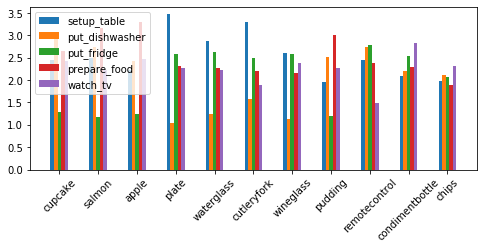

In [60]:
fig, ax2 = plt.subplots(1,1, figsize=(8,3))
x = np.array(range(len(objects_interest)))
for idi in range(len(names)):
    gap = idi + 0.5 - len(names)/2
    gap *= 1./(len(objects_interest))
    gp = 1./(len(objects_interest))
    ax2.bar(x+gap, list(all_count_mean[idi]), width=gp, label=names[idi])
    ax2.set_xticks(x)
    ax2.set_xticklabels(objects_interest, rotation=45)
    plt.legend()

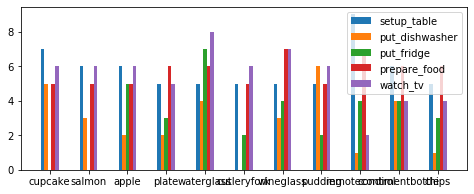

In [38]:
fig, ax2 = plt.subplots(1,1, figsize=(8,3))
x = np.array(range(len(objects_interest)))
for idi in range(len(names)):
    gap = idi + 0.5 - len(names)/2
    gap *= 1./(len(objects_interest))
    gp = 1./(len(objects_interest))
    ax2.bar(x+gap, list(all_count_max[idi]), width=gp, label=names[idi])
    ax2.set_xticks(x)
    ax2.set_xticklabels(objects_interest)
    plt.legend()

Text(0.5, 1.0, 'Length Episode')

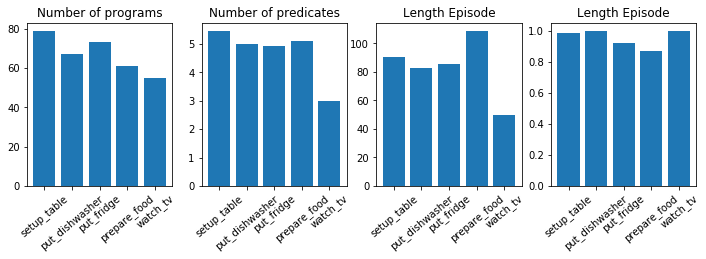

In [61]:

fig, ax2 = plt.subplots(1,4, figsize=(12,3))
x = range(len(names))
ax = ax2[0]
ax.bar(x, count_episodes)
ax.set_xticks(x)
ax.set_xticklabels(names,  rotation=40)
ax.set_title('Number of programs')

ax = ax2[1]
ax.bar(x, count_pred)
ax.set_xticks(x)
ax.set_xticklabels(names, rotation=40)
ax.set_title('Number of predicates')

ax = ax2[2]
ax.bar(x, count_length)
ax.set_xticks(x)
ax.set_xticklabels(names,  rotation=40)
ax.set_title('Length Episode')

ax = ax2[3]
ax.bar(x, count_success)
ax.set_xticks(x)
ax.set_xticklabels(names,  rotation=40)
ax.set_title('Length Episode')

In [ ]:
lents = [cont['len_prog'] for cont in results if len(cont) > 0 and cont['finished'] and cont['len_prog'] < 150]

In [ ]:
len(lents)

In [ ]:
# Agregate relstions
aggregate_relations = {}

all_relation_names = []
for result in results:
    result_rel = result['obj_relations']
    for result_object, counter_result in result_rel.items():
        all_relation_names += list(counter_result.keys())

all_relation_names = list(set(all_relation_names))
relation_name_to_index = {rel_name: ind for ind, rel_name in enumerate(all_relation_names)}

# For every object, a list of counts
all_relations = {}
for task_name in names:
    all_relations[task_name] = {}
    for object_name_interest in objects_interest:
        all_relations[task_name][object_name_interest] = [0 for _ in all_relation_names]
    
for result in results:
    task_name = result['pred_name']
    result_rel = result['obj_relations']
    for result_object, counter_result in result_rel.items():
        for relation_name, relation_count in counter_result.items():
            index = relation_name_to_index[relation_name]
            all_relations[task_name][result_object][index] += relation_count

# Average over episodes
for index_task, task_name in enumerate(names):
    count_ep = count_length[index_task]
    for object_interest in objects_interest:
        all_relations[task_name][object_interest] = np.array(all_relations[task_name][object_interest])/count_ep
            
            
# len(all_relation_names)

# for result in results:
#     for obj_name in objects_interest:
        
# results[0]['obj_relations']

In [ ]:
for task_name in [names[0]]:
    fig, ax2 = plt.subplots(len(objects_interest),1, figsize=(8, 8))
    for it_object_interest, name in enumerate(objects_interest):
        print(name)
        array_res = all_relations[task_name][name]
        print(array_res)
        array_res = list(array_res)
        for it, elem in enumerate(array_res):
            relation_name = all_relation_names[it]
            ax2[it_object_interest].bar(it, array_res[it], label=relation_name)
            ax.set_xticks([])


In [ ]:
print(len(objects_interest))
fig, ax2 = plt.subplots(len(objects_interest),1, figsize=(12, 4*len(objects_interest)))
for id_task_name, task_name in enumerate(names):
    pattern = ["", "//", '**', '\\'][id_task_name]
    for it_object_interest, name in enumerate(objects_interest):
#         print(name)
        array_res = all_relations[task_name][name]
#         print(array_res)
        array_res = list(array_res)
        colors = list(mcd.CSS4_COLORS.values())
        for it, elem in enumerate(array_res):
            relation_name = all_relation_names[it]
#             ax2[it_object_interest].bar(it*2 + id_task_name, array_res[it], label=relation_name, width=0.5)
            gp = 1./len(names)
            gap = gp * (id_task_name +0.5 - len(names)/2.)
            ax2[it_object_interest].bar(it + gap, array_res[it], width=gp, 
                                        label=relation_name, hatch=pattern,  color=colors[it % len(colors)])
        
        ax2[it_object_interest].set_title(name)
        ax2[it_object_interest].set_ylim([0,2])
        ax2[it_object_interest].set_xticks(range(len(array_res)))
        ax2[it_object_interest].set_xticklabels(all_relation_names, rotation=40)
        ax2[it_object_interest].grid(axis='y')
#     if id_task_name == 0:
#         plt.legend(ncol=3)

In [ ]:

fig, ax2 = plt.subplots(4,1, figsize=(12, 8))
for id_task_name, task_name in enumerate(names):
    pattern = ["", "//"][id_task_name]
    for it_object_interest, name in enumerate(objects_interest[:1]):
#         print(name)
        array_res = all_relations[task_name][name]
#         print(array_res)
        array_res = list(array_res)
        for it, elem in enumerate(array_res):
            relation_name = all_relation_names[it]
#             ax2[it_object_interest].bar(it*2 + id_task_name, array_res[it], label=relation_name, width=0.5)
            ax2[it_object_interest].bar(it*2 + id_task_name, array_res[it], label=relation_name, hatch=pattern)
        
        ax2[it_object_interest].set_title(name)
        ax2[it_object_interest].set_ylim([0,100])
        ax2[it_object_interest].set_xticks([])
        
        ax2[it_object_interest].grid(axis='y')
    if id_task_name == 0 and it_object_interest == 0:
#         ax2[0].legend(ncol=4)
        ax2[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))